In [2]:
### let's try loading the video and examine the frames


%pylab inline
%load_ext autoreload
%autoreload 2

import os
import sys
sys.argv=['']
sys.path.append('/nethome/jbang36/eva_storage')


import numpy as np
#import utils.helpers as helpers
import utils as helpers
from loaders.uadetrac_loader import UADetracLoader
from eva_storage.preprocessingModule import PreprocessingModule
from eva_storage.UNet import UNet
from eva_storage.clusterModule import ClusterModule
from filters.minimum_filter import FilterMinimum

from loaders.decompressionModule import DecompressionModule
from miscellaneous_code import *

Populating the interactive namespace from numpy and matplotlib


In [3]:

video_directory = '/nethome/jbang36/eva_storage/data/seattle/seattle2.mov'


In [4]:
decompressionModule = DecompressionModule()

In [5]:
images = decompressionModule.convert2images(video_directory, frame_count_limit = 1000000)

06-11-2020 20:44:35 [info:049]INFO : meta data of the video /nethome/jbang36/eva_storage/data/seattle/seattle2.mov is (168601, 241, 369, 3)


In [6]:

images.shape

(168601, 241, 369, 3)

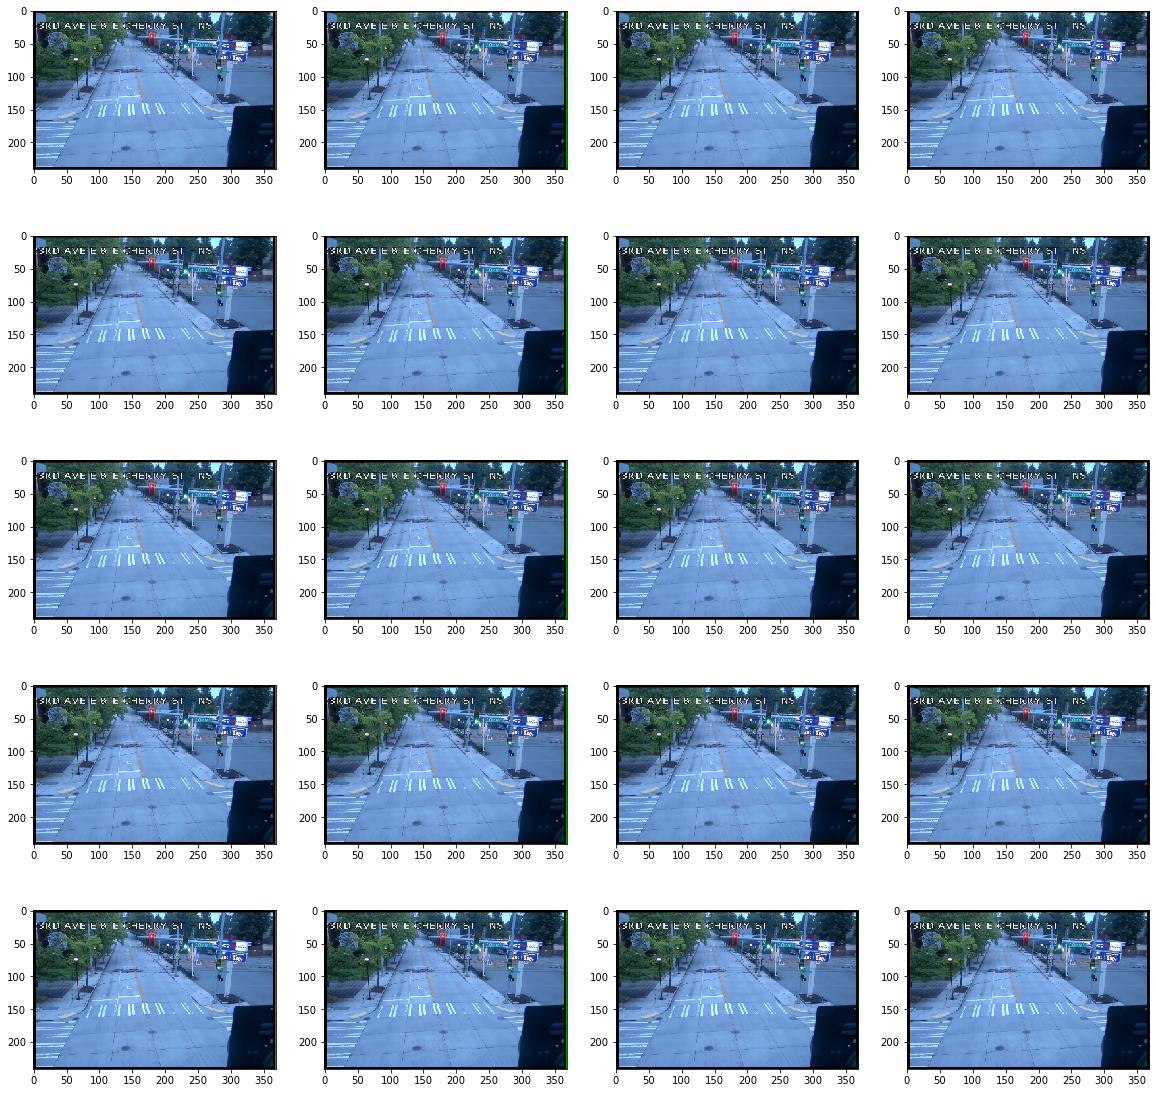

In [7]:
draw_multiple_images(images)

In [8]:
#### let's upload the ssd model and use it for evaluation
import torchvision

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)



In [9]:
import torch
import cv2

In [10]:
model.eval()



FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
  

In [11]:
### now we need to load the dataset.. create a dataloader object
import torch


class SeattleDataset(torch.utils.data.Dataset):
    """`MS Coco Detection <http://mscoco.org/dataset/#detections-challenge2016>`_ Dataset.
    Args:
        root (string): Root directory where images are downloaded to.
        set_name (string): Name of the specific set of COCO images.
        transform (callable, optional): A function/transform that augments the
                                        raw images`
        target_transform (callable, optional): A function/transform that takes
        in the target (bbox) and transforms it.
    """
    def __init__(self, transform=None):

        self.transform = transform

        self.root = ""
        self.image_width = -1
        self.image_height = -1
        self.X_train = None
        self.y_train = None

    def __getitem__(self, index):
        """
        Function that is called when doing enumeration / using dataloader
        :param index:
        :return:
        """
        return self.pull_item(index)

    def set_images(self, images):
        self.X_train = images

    def provide_args(self):
        return None

    def pull_item(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: Tuple (image, target, height, width).
                   target is the object returned by ``coco.loadAnns``.
        """
        img = self.X_train[index]
        args = self.provide_args()
        if self.transform is not None:
            ## we expect this code to run only if target_trans
            img = self.transform(img, args)

        if self.y_train is not None:
            target = self.y_train[index]
            
        img = cv2.resize(img, (300,300))
            
        img_t = torch.from_numpy(img).permute(2,0,1).float()
        img_t /= 255.0 ## must normalize the image for fasterrcnn
        return img_t


    def pull_image(self, index):
        '''Returns the original image object at index in PIL form

        Note: not using self.__getitem__(), as any transformations passed in
        could mess up this functionality.

        Argument:
            index (int): index of img to show
        Return:
            cv2 img
        '''
        return self.X_train[index] ## note this images is BRG


    def __len__(self):
        return len(self.X_train)




In [12]:
def createTorchDataLoader(images, batch_size = 16, shuffle = False):
    import torch
    dataset = SeattleDataset()
    dataset.set_images(images)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=1)


In [13]:
dataLoader = createTorchDataLoader(images, shuffle = False)

In [12]:
model.cpu()

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
  

In [1]:
from tqdm import tqdm

In [ ]:
## now let's evaluate this thing

all_annotations = []

for i, data_batch in enumerate(tqdm(dataLoader)):
    image_batch = data_batch
    ## need to move to cuda
    image_batch = image_batch
    images_list = list(image for image in image_batch)
    annotations = model(images_list)
    all_annotations.append(annotations)
    
    



  0%|          | 14/10538 [08:09<104:58:16, 35.91s/it]